# Alignment problem
1. FASTQ Preparation and Exploration
2. Naive Exact Matching Algorithm (Online Algorithm) 
3. Boyer-Moore (Online Algorithm)
4. Index Assisted Algorithms (Offline Algorithm)
5. Edit distance

## 1. FASTQ Preparation and Exploration

### 1.1. Quality Score Histogram
This function is used to visualize the distribution of quality scores in sequencing data, which provides insights into the sequencing data's quality and potential biases. 

In [16]:
#read FASTQ
from readFASTQ import readFASTQ

phix_reads, qualities = readFASTQ('ERR266411_1.first1000.fastq')

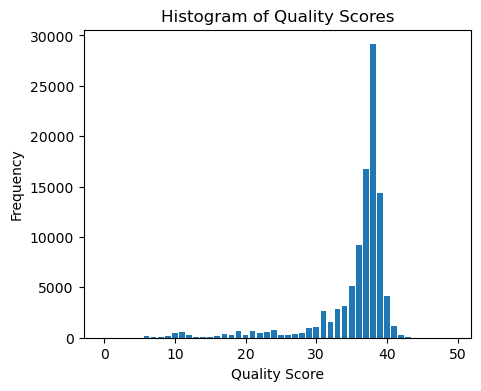

In [38]:
from exploration_FASTQ import phred33ToQ, qualityScore_hist, findGCbyPosition
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate a histogram of quality scores
hist = qualityScore_hist(qualities)

# Plot histogram
plt.figure(figsize=(5, 4))
plt.bar(range(len(hist)), hist)
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.title('Histogram of Quality Scores')
plt.show()

### 1.2. GC Content by Position
The function typically returns a profile or plot showing how GC content varies along the sequences. It is valuable for understanding sequence characteristics.

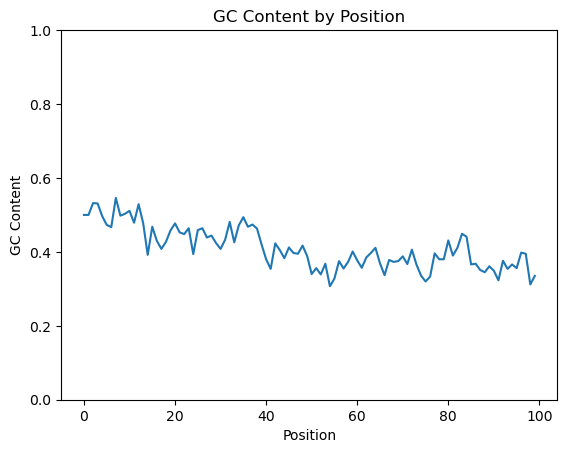

In [39]:
# calculate GC content by position
gc = findGCbyPosition(phix_reads)

#plot the graph
plt.plot(range(len(gc)), gc)
plt.yticks([0, 1], minor=True)
plt.xlabel('Position')
plt.ylabel('GC Content')
plt.title('GC Content by Position')
plt.show()

In [40]:
import collections
count = collections.Counter()
for read in phix_reads:
    count.update(read)
print(count)

Counter({'T': 30531, 'A': 28426, 'C': 21890, 'G': 19147, 'N': 6})


## 2. Naive Exact Matching Algorithm (Online Algorithm)

### 2.1. Using the naive exact matching to find the reads that matches referece genome
- The reads from FASTQ file ('ERR266411_1.first1000.fastq') will be match on the genome reference from FASTA file ('phix.fa')
- Count the number of reads (first 30 bases/prefix) that match the genome, considering both the forward and reverse strands of the reads.

In [34]:
#read FASTA
from readFASTA import readFASTA
genome_reference = readFASTA('phix.fa')

In [26]:
from alignment_naive_matching import count_matched_reads

reads_matched, all_reads = count_matched_reads(phix_reads, genome_reference)
print('%d / %d reads matched the genome' % (reads_matched, all_reads) )

932 / 1000 reads matched the genome


### 2.2. Using the naive exact matching to find the pattern that matches referece genome
The pattern is searched in the reference genome to find the occurrences that matches using naive exact match. Both the forward and reverse strands of the pattern are considered.

In [27]:
from alignment_naive_matching import naive_with_rc

#test the function
p = 'TTAA'
ten_as = 'AAAAAAAAAA'
t = ten_as + 'TTAA' + ten_as + 'TTAA' + ten_as
occurrences, occurrences_rc = naive_with_rc(p, t)
print(occurrences, occurrences_rc)
print('ocurrences of pattern: %d' %(len(occurrences)))
print('ocurrences of its complement: %d' %(len(occurrences_rc)))
print('ocurrences of all: %d' %(len(occurrences) + len(occurrences_rc)))
print('offset of leftmost occurrence of pattern: %d' %(min(occurrences)))
print('offset of leftmost occurrence of its complement: %d' %(min(occurrences_rc)))

[10, 24] [10, 24]
ocurrences of pattern: 2
ocurrences of its complement: 2
ocurrences of all: 4
offset of leftmost occurrence of pattern: 10
offset of leftmost occurrence of its complement: 10


In [28]:
#find the pattern in genome reference (in 'phix.fa' file)
p = 'TTAA'
occurrences, occurrences_rc = naive_with_rc(p, genome_reference)
print('ocurrences of pattern: %d' %(len(occurrences)))
print('ocurrences of its complement: %d' %(len(occurrences_rc)))
print('ocurrences of all: %d' %(len(occurrences) + len(occurrences_rc)))
print('offset of leftmost occurrence of pattern: %d' %(min(occurrences)))
print('offset of leftmost occurrence of its complement: %d' %(min(occurrences_rc)))

ocurrences of pattern: 35
ocurrences of its complement: 35
ocurrences of all: 70
offset of leftmost occurrence of pattern: 28
offset of leftmost occurrence of its complement: 28


In [29]:
#find the pattern in genome reference (in 'phix.fa' file)
p = 'AGTCG'
occurrences, occurrences_rc = naive_with_rc(p, genome_reference)
print('ocurrences of pattern: %d' %(len(occurrences)))
print('ocurrences of its complement: %d' %(len(occurrences_rc)))
print('ocurrences of all: %d' %(len(occurrences) + len(occurrences_rc)))
print('offset of leftmost occurrence of pattern: %d' %(min(occurrences)))
print('offset of leftmost occurrence of its complement: %d' %(min(occurrences_rc)))

ocurrences of pattern: 2
ocurrences of its complement: 8
ocurrences of all: 10
offset of leftmost occurrence of pattern: 53
offset of leftmost occurrence of its complement: 1116


### 2.3.  Using Naive Exact Matching to Find the Pattern That Matches the Reference Genome Allowing 2 Mismatches (Approximate Matching)

The pattern is searched in the reference genome to find occurrences that match using naive exact matching, allowing for up to 2 mismatches. Only the forward strands of the pattern are considered.

In [7]:
from alignment_naive_matching import naive_matching_2mm

#test
p = 'CTGT'
ten_as = 'AAAAAAAAAA'
t = ten_as + 'CTGT' + ten_as + 'CTTT' + ten_as + 'CGGG' + ten_as
occurrences = naive_matching_2mm(p, t)
print(occurrences)
print('ocurrences of pattern: %d' %(len(occurrences)))
print('offset of leftmost occurrence: %d' % min(occurrences))

[10, 24, 38]
ocurrences of pattern: 3
offset of leftmost occurrence: 10


In [31]:
#find the pattern in genome reference (in 'phix.fa' file) using 'naive_matching_2mm'
p = 'CTACAGGTCGCGTTGACCCAAATT'
occurrences = naive_matching_2mm(p, genome_reference)
print('ocurrences of pattern: %d' %(len(occurrences)))
print('offset of leftmost occurrence: %d' % min(occurrences))

ocurrences of pattern: 1
offset of leftmost occurrence: 4800


## 3. Boyer-Moore (Online Algorithm)

### 3.1. Comparing Boyer-Moore with Naive Exact Matching
The number of alignments (num_alignments) and the number of characters compared (num_character_comparisons) are compared between the two algorithms. It can be observed that Boyer-Moore is capable of skipping more characters and is faster than naive exact matching."

In [32]:
#naive exact matching
from alignment_naive_matching import naive_with_counts

#test
%time
p = 'meow'
t = 'pathetic pathetic meow meow'
occurrences, num_alignments, num_character_comparisons = naive_with_counts(p, t)
print(occurrences, num_alignments, num_character_comparisons)
print('occurrence of pattern: {}'.format(occurrences))
print('number of alignments: %d' %(num_alignments))
print('number of characters compared: %d' %(num_character_comparisons))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
[18, 23] 24 30
occurrence of pattern: [18, 23]
number of alignments: 24
number of characters compared: 30


In [33]:
#find the pattern in reference genome using naive exact matching

%time
p = 'GCGTTGCGTCTATTATGGAAAACACCAATCTTTCCAAGCAACAGCAGGTTT'
occurrences, num_alignments, num_character_comparisons = naive_with_counts(p, genome_reference)
print(occurrences, num_alignments, num_character_comparisons)
print('occurrence of pattern: {}'.format(occurrences))
print('number of alignments: %d' %(num_alignments))
print('number of characters compared: %d' %(num_character_comparisons))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
[3555] 5336 7073
occurrence of pattern: [3555]
number of alignments: 5336
number of characters compared: 7073


In [34]:
#boyer-moore
from alignment_boyer_moore import boyer_moore_with_counts
from bm_preproc import BoyerMoore
lowercase_alphabet = 'abcdefghijklmnopqrstuvwxyz ' #for preprocessing

#test
%time
p = 'meow'
t = 'pathetic pathetic meow meow'
p_bm = BoyerMoore(p, lowercase_alphabet)
occurrences, num_alignments, num_character_comparisons = boyer_moore_with_counts(p, p_bm, t)
print(occurrences, num_alignments, num_character_comparisons)
print('occurrence of pattern: {}'.format(occurrences))
print('number of alignments: %d' %(num_alignments))
print('number of characters compared: %d' %(num_character_comparisons))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs
[18, 23] 8 14
occurrence of pattern: [18, 23]
number of alignments: 8
number of characters compared: 14


In [35]:
#find the pattern in reference genome using boyer-moore

%time
p = 'GCGTTGCGTCTATTATGGAAAACACCAATCTTTCCAAGCAACAGCAGGTTT'
p_bm = BoyerMoore(p, alphabet='ATGC')
occurrences, num_alignments, num_character_comparisons = boyer_moore_with_counts(p, p_bm, genome_reference)
print(occurrences, num_alignments, num_character_comparisons)
print('occurrence of pattern: {}'.format(occurrences))
print('number of alignments: %d' %(num_alignments))
print('number of characters compared: %d' %(num_character_comparisons))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
[3555] 862 1352
occurrence of pattern: [3555]
number of alignments: 862
number of characters compared: 1352


### 3.2. Implementing Boyer Moore with the Pigeonhole Principle

In [37]:
from alignment_boyer_moore_pigeonhole import bm_approximate_matching

#test + allow 2 mismatches
p = 'AACTTG'
t = 'CACTTAATTTG'
print(bm_approximate_matching(p, t, 2))

[0, 5]


In [38]:
# find the pattern in genome reference (in 'phix.fa' file) using bm with the pigeonhole principle
# give same result of using function 'naive_matching_2mm'

%time
p = 'CTACAGGTCGCGTTGACCCAAATT'
occurrences = bm_approximate_matching(p, genome_reference, 2)
print('ocurrences of pattern: %d' %(len(occurrences)))
print('offset of leftmost occurrence: %d' % min(occurrences))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
ocurrences of pattern: 1
offset of leftmost occurrence: 4800


## 4. Index Assisted Algorithms (Offline Algorithm) 

### 4.1. Implementing Substring Index for Exact Matching

In [19]:
from kmerIndex_binarySearch import Index
from alignment_queryIndex_exactMatching import queryIndex_exactMatching

#test
t = 'AAATGCGCGCGCATGCGGG'
p = 'ATGC'

#Collect all positions where the 2-mer (of pattern) matches in the text
index = Index(t, 2)
print('all indext: {}'.format(index.index))
#a verification step to confirm the correctness of hits obtained 
print(queryIndex_exactMatching(p, t, index))

all indext: [('AA', 0), ('AA', 1), ('AT', 2), ('AT', 12), ('CA', 11), ('CG', 5), ('CG', 7), ('CG', 9), ('CG', 15), ('GC', 4), ('GC', 6), ('GC', 8), ('GC', 10), ('GC', 14), ('GG', 16), ('GG', 17), ('TG', 3), ('TG', 13)]
[2, 12]


In [20]:
#find the pattern in reference genome using naive exact matching and substring index

p = 'GCGTTGCGTCTATTATGGAAAACACCAATCTTTCCAAGCAACAGCAGGTTT'
index = Index(genome_reference, 30)
occurrences = queryIndex_exactMatching(p, genome_reference, index)
print('occurrence of pattern: {}'.format(occurrences))

occurrence of pattern: [3555]


### 4.2. Implementing Substring Index for Approximate Matching
First, implement the pigeonhole principle using an index to find exact matches for the partitions. For the verification step, we are looking for approximate matches with up to a defined number of mismatches (substitutions).

In [65]:
#!/usr/bin/env python

# Author: Chiranan Khantham

import bisect

def queryIndex_approximate_matching(p, t, t_index, n):
    """
    Find approximate occurrences of a pattern in a text using an indexed search.

    Parameters:
    - p (str): The pattern to search for in the text.
    - t (str): The text where the pattern is to be searched.
    - t_index (Index): The index of the text constructed using an indexing method.
    - n (int): The maximum number of mismatches allowed.

    Returns:x
    - tuple: A tuple containing two elements:
        - list: A list containing the starting positions of approximate occurrences of the pattern in the text.
        - list: A list containing the hits found during the indexed search.
    """
        
    segment_length = int(round(len(p) / (n+1)))
    kmers = []
    all_matches = set()
    hits = []
    
    for a in range(n+1):
        start = a * segment_length
        end = min((a+1) * segment_length, len(p))
        kmer = p[start:end]
        kmers.append(kmer)
    print('kmers of pattern are: {}'. format(kmers))
    
    for k in kmers:
        i = bisect.bisect_left(t_index.index, (k, -1))
        while i < len(t_index.index):
            if t_index.index[i][0] != k:
                break
            hits.append(t_index.index[i][1])
            i += 1
            
        # Check if the match is within bounds
        for m in hits:
            if m < start or m-start+len(p) > len(t):
                continue
            mismatches = 0
            
            # Check mismatches before the start index
            for j in range(0, start):
                if not p[j] == t[m-start+j]:
                    mismatches += 1
                    if mismatches > n:
                        break
            
            # Check mismatches after the end index
            for j in range(end, len(p)):
                if not p[j] == t[m-start+j]:
                    mismatches += 1
                    if mismatches > n:
                        break
                        
            # If total mismatches are within the allowed limit, add the match index to the set 
            # m - start to get the position of text which match with the first offset of pattern
            if mismatches <= n:
                all_matches.add(m - start)
                
    return list(all_matches), sorted(hits)


In [66]:
#this need to be fix!!!!!!!
#from alignment_queryIndex_approximate_matching import queryIndex_approximate_matching

#test
p = 'CTGTAA' #allow 2 mismatch the p will be split into 3 paritions CT, GT
ten_as = 'AAAAAAAAAA'
t = ten_as + 'CTGT' + ten_as + 'CTTT' + ten_as + 'CGGG' + ten_as
index = Index(t, 2)
print('all indext: {}'.format(index.index))

all_matches, hits = queryIndex_approximate_matching(p, t, index, 2)
print('occurrences: {}'. format (all_matches))
print('number of all hits: {}'. format(hits))

all indext: [('AA', 0), ('AA', 1), ('AA', 2), ('AA', 3), ('AA', 4), ('AA', 5), ('AA', 6), ('AA', 7), ('AA', 8), ('AA', 14), ('AA', 15), ('AA', 16), ('AA', 17), ('AA', 18), ('AA', 19), ('AA', 20), ('AA', 21), ('AA', 22), ('AA', 28), ('AA', 29), ('AA', 30), ('AA', 31), ('AA', 32), ('AA', 33), ('AA', 34), ('AA', 35), ('AA', 36), ('AA', 42), ('AA', 43), ('AA', 44), ('AA', 45), ('AA', 46), ('AA', 47), ('AA', 48), ('AA', 49), ('AA', 50), ('AC', 9), ('AC', 23), ('AC', 37), ('CG', 38), ('CT', 10), ('CT', 24), ('GA', 41), ('GG', 39), ('GG', 40), ('GT', 12), ('TA', 13), ('TA', 27), ('TG', 11), ('TT', 25), ('TT', 26)]
kmers of pattern are: ['CT', 'GT', 'AA']
occurrences: [24, 10, 38]
number of all hits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [67]:
#Assume P always has length 24
#we are looking for approximate matches with up to 2 mismatches (substitutions)
#the pattern will be splitted into 2+1 parts = 24/3 = 8
#We will use an 8-mer index

p = 'CTACAGGTCGCGTTGACCCAAATT'
index = Index(genome_reference, 8)
all_matches, hits = queryIndex_approximate_matching(p, genome_reference, index, 2)
print('all matches: {}'.format(all_matches))
print('number of all hits: {}'. format(hits))

# give same result of using function 'naive_matching_2mm'

kmers of pattern are: ['CTACAGGT', 'CGCGTTGA', 'CCCAAATT']
all matches: []
number of all hits: [4800]


### 4.3. Implementing Subsequence for Exact Matching

In [3]:
from subSeqIndex_binarySearch import SubseqIndex

t = 'ATATAT'
p = 'TTATAT'
a = SubseqIndex(t , 3, 2)
print(a.index)
print(a.span) #window

print(a.query(p[0:])) #search TAA in a
print(a.query(p[1:])) #search TTT in a => Return index hits for first subseq of p 

[('AAA', 0), ('TTT', 1)]
5
[]
[1]


In [4]:
from alignment_querySubseq_exactMatching import querySubseq_exactMatching

t = 'to-morrow and to-morrow and to-morrow creeps in this petty pace'
p = 'to-morrow and to-morrow '
subseq_index = SubseqIndex(t, 8, 3)
print('all indext: {}'.format(subseq_index.index))
print('window: {}'. format(subseq_index.span))
occurrences, indexHit = querySubseq_exactMatching(p, t, subseq_index)
print('occurrences: {}'. format (occurrences))
print('number of all hits: {}'. format(indexHit))

all indext: [(' -rwntmr', 13), (' -rwrpit', 27), (' doooa -', 9), (' doooce ', 23), (' esnh t ', 37), ('-rwntmr ', 2), ('-rwntmr ', 16), ('-rwrpits', 30), ('a -rwntm', 10), ('a -rwrpi', 24), ('ce  iptp', 38), ('doooa -r', 12), ('doooce  ', 26), ('e  iptpe', 41), ('esnh t c', 40), ('mr doooa', 3), ('mr doooc', 17), ('mr esnh ', 31), ('ntmr doo', 11), ('ntmr esn', 25), ('oa -rwnt', 7), ('oa -rwrp', 21), ('oce  ipt', 35), ('ooa -rwn', 4), ('ooa -rwr', 18), ('ooce  ip', 32), ('oooa -rw', 1), ('oooa -rw', 15), ('oooce  i', 29), ('r doooa ', 6), ('r doooce', 20), ('r esnh t', 34), ('rpitseya', 39), ('rwntmr d', 5), ('rwntmr e', 19), ('rwrpitse', 33), ('tmr dooo', 0), ('tmr dooo', 14), ('tmr esnh', 28), ('wntmr do', 8), ('wntmr es', 22), ('wrpitsey', 36)]
window: 22
occurrences: [0, 14]
number of all hits: 6


In [5]:
#test
t = 'AAATGCGCGCGCATGCGGG'
p = 'ATGC'

subseq_index = SubseqIndex(t, 2, 2)
print('all indext: {}'.format(subseq_index.index))
print('window: {}'. format(subseq_index.span))
occurrences, indexHit = querySubseq_exactMatching(p, t, subseq_index)
print('occurrences: {}'. format (occurrences))
print('number of all hits: {}'. format(indexHit))

all indext: [('AA', 0), ('AG', 2), ('AG', 12), ('AT', 1), ('CC', 5), ('CC', 7), ('CC', 9), ('CG', 15), ('CT', 11), ('GA', 10), ('GG', 4), ('GG', 6), ('GG', 8), ('GG', 14), ('GG', 16), ('TC', 3), ('TC', 13)]
window: 3
occurrences: [2, 12]
number of all hits: 4


### 4.4. Implementing Subsequence for Approximate Matching
First, implement the pigeonhole principle using an subsequence index to find exact matches for the partitions. For the verification step, we are looking for approximate matches with up to a defined number of mismatches (substitutions).

In [17]:
from alignment_querySubseq_approximate_matching import querySubseq_approximate_matching

#test
p = 'CTGT'
ten_as = 'AAAAAAAAAA'
t = ten_as + 'CTGT' + ten_as + 'CTTT' + ten_as + 'CGGG' + ten_as
subseq_index = SubseqIndex(t, 2, 2)
all_matches, hits = querySubseq_approximate_matching(p, t, subseq_index, 2)
print('occurrences: {}'. format (all_matches))
print('number of all hits: {}'. format(hits))

occurrences: [24, 10, 38]
number of all hits: [10, 38, 11, 25]


In [25]:
p = 'CTACAGGTCGCGTTGACCCAAATT'
subseq_index = SubseqIndex(genome_reference, 8, 3)
all_matches, hits = querySubseq_approximate_matching(p, genome_reference, subseq_index, 2)
print('occurrences: {}'. format (all_matches))
print('number of all hits: {}'. format(hits))

occurrences: [4800]
number of all hits: [4800]


# 5. Edit distance
Edit distance, also known as Levenshtein distance, is a metric used to quantify the similarity between two strings. In the context of sequence alignment, such as DNA or protein sequence alignment, edit distance refers to the minimum number of operations required to transform one sequence into another.

In bioinformatics, edit distance is often used to measure the similarity between DNA sequences, protein sequences, or other biological sequences. It provides a quantitative measure of how closely related two sequences are, based on the minimal number of changes required to transform one sequence into the other.

## 5.1. Naive Edit Distance with Recursive Approach
- The recursive approach breaks down the problem into smaller subproblems and solves them recursively.
- Base Cases: If one of the strings is empty, the edit distance is simply the length of the other string. <br>
- Recursive Step: If both strings are non-empty, the function considers three possible operations: <br>
    - Horizontal: Represents inserting a character into x to match y. <br>
    - Vertical: Represents deleting a character from x to match y. <br>
    - Diagonal: Represents substituting or matching characters from x to y.<br>
- The function recursively calculates the edit distances for these operations and returns the minimum of these distances.
- This recursive approach can be inefficient for large inputs due to recalculating the same subproblems multiple times.

In [17]:
from alignment_editDistanceRecursive import editDistanceRecursive

%time
x = 'patheticMeowMeow'
y = 'pathetic meow meow'
editDistanceRecursive(x, y)

CPU times: user 7 µs, sys: 5 µs, total: 12 µs
Wall time: 31 µs


KeyboardInterrupt: 

In [2]:
%time
x = 'TATGTCATGC'
y = 'TATGGCAGC'
editDistanceRecursive(x, y)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs


2

## 5.2. Edit Distance with Dynamic Programming Approach
- The dynamic programming approach uses a bottom-up approach to iteratively fill in a matrix that represents the edit distances between all possible substrings of the input strings.
- It avoids redundant calculations by storing the results of subproblems in the matrix.
- This approach has a time complexity of O(m*n), where m and n are the lengths of the input strings, making it much more efficient than the recursive approach for larger inputs.

In [9]:
from alignment_editDistance import editDistance

%time
x = 'patheticMeowMeow'
y = 'pathetic meow meow'
editDistance(x, y)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


4

In [16]:
%time
x = 'TATGTCATGC'
y = 'TATGGCAGC'
editDistance(x, y)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


2

## 5.3. Edit Distance with Approximate Matching
The function editDistance_approximate_matching(x, y) calculates the approximate edit distance between two strings x and y. In this context, approximate matching typically refers to finding the minimum number of single-character edits (insertions, deletions, or substitutions) required to make the strings identical, **with an additional allowance for mismatches**.

In [22]:
from alignment_editDistance_approximate_matching import editDistance_approximate_matching

t = 'TATTGGCTATACGGTT'
p = 'GCGTATGC'
edit_distance = editDistance_approximate_matching(p, t)
print(edit_distance)

2


In [23]:
p = 'CTACAGGTCGCGTTGACCCAAATT'
edit_distance = editDistance_approximate_matching(p, genome_reference)
print(edit_distance)

2


In [24]:
p = 'CTACAGGTCGCGTTGACCCAAAAA'
edit_distance = editDistance_approximate_matching(p, genome_reference)
print(edit_distance)

4


## 5.4. Global Alignment
This Python function globalAlignment(x, y) computes the global alignment score between two sequences x and y using dynamic programming. Global alignment is a method used in bioinformatics to find the optimal alignment between two sequences, considering insertions, deletions, and substitutions.

In [19]:
from alignment_globalAlignment import globalAlignment

x = 'TATGTCATGC'
y = 'TATGGCAGC'
score = globalAlignment(x,y)
print("Global alignment score: {}". format(score))
print("The alignment score of 12 indicates that the optimal alignment between x and y involves\n\
      a combination of matches, mismatches, insertions, and deletions that\n\
      result in a total cumulative cost of 12 based on this scoring scheme")

Global alignment score: 12
The alignment score of 12 indicates that the optimal alignment between x and y involves
      a combination of matches, mismatches, insertions, and deletions that
      result in a total cumulative cost of 12 based on this scoring scheme
